In [68]:
# import required modules
import random
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics, preprocessing
import copy
from torch_geometric.utils import degree

import torch
from torch import nn, optim, Tensor

from torch_sparse import SparseTensor, matmul

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.data import download_url, extract_zip
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.typing import Adj

In [69]:
# download the dataset
# https://grouplens.org/datasets/movielens/
# "Small: 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. Last updated 9/2018"
url = 'https://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
extract_zip(download_url(url, '.'), '.')

movie_path = './ml-latest-small/movies.csv'
rating_path = './ml-latest-small/ratings.csv'
user_path = './ml-latest-small/users.csv'

Using existing file ml-latest-small.zip
Extracting ./ml-latest-small.zip


In [70]:
rating_df = pd.read_csv(rating_path)

print(rating_df.head())

print(len(rating_df['movieId'].unique()))
print(len(rating_df['userId'].unique()))

rating_df.describe()

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931
9724
610


,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [71]:
# perform encoding preprocessing to ensure that user_id and item_id are both 
# in the range of [0, unique_count] so it won't cause out of bound issue when indexing embeddings
lbl_user = preprocessing.LabelEncoder()
lbl_movie = preprocessing.LabelEncoder()

rating_df.userId = lbl_user.fit_transform(rating_df.userId.values)
rating_df.movieId = lbl_movie.fit_transform(rating_df.movieId.values)

In [72]:
print(rating_df.userId.max())
print(rating_df.movieId.max())

609
9723


In [73]:
rating_df.rating.value_counts()

rating
4.0    26818
3.0    20047
5.0    13211
3.5    13136
4.5     8551
2.0     7551
2.5     5550
1.0     2811
1.5     1791
0.5     1370
Name: count, dtype: int64

In [74]:
# load edges between users and movies
def load_edge_csv(df, 
                  src_index_col, 
                  dst_index_col, 
                  link_index_col, 
                  rating_threshold=3):
    """Loads csv containing edges between users and items

    Args:
        src_index_col (str): column name of users
        dst_index_col (str): column name of items
        link_index_col (str): column name of user item interaction
        rating_threshold (int, optional): Threshold to determine positivity of edge. Defaults to 4.

    Returns:
        list of list: edge_index -- 2 by N matrix containing the node ids of N user-item edges
        N here is the number of interactions
    """
    
    edge_index = None
    
    # Constructing COO format edge_index from input rating events
    
    # get user_ids from rating events in the order of occurance
    src = [user_id for user_id in df['userId']]
    # get movie_id from rating events in the order of occurance
    dst = [(movie_id) for movie_id in df['movieId']]

    # apply rating threshold
    edge_attr = torch.from_numpy(df[link_index_col].values).view(-1, 1).to(torch.long) >= rating_threshold
    # print(edge_attr)
    # print(edge_attr.shape)

    edge_index = [[], []]
    for i in range(edge_attr.shape[0]):
        if edge_attr[i]:
            edge_index[0].append(src[i])
            edge_index[1].append(dst[i])
    return edge_index

In [75]:
edge_index = load_edge_csv(
    rating_df,
    src_index_col='userId',
    dst_index_col='movieId',
    link_index_col='rating',
    rating_threshold=3.5, 
)

print(f"{len(edge_index)} x {len(edge_index[0])}")

2 x 48580


In [76]:
# type(edge_index)
print(edge_index)
# torch.from_numpy(rating_df['rating'].values).view(-1, 1).to(torch.long) >= 3.5

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [77]:
# Convert to tensor
# We use LongTensor here because the .propagate() method in the model needs either LongTensor or SparseTensor
edge_index = torch.LongTensor(edge_index)
print(edge_index)
print(edge_index.size())

tensor([[   0,    0,    0,  ...,  609,  609,  609],
        [   0,    2,    5,  ..., 9443, 9444, 9445]])
torch.Size([2, 48580])


In [78]:
x = torch.randn(4, 4)
print(x)
print(x.size())
y = x.view(-1, 1)
print("y size", y.size())
print("y", y)
z = x.view(-1, 8)  # the size -1 is inferred from other dimensions
z.size()


tensor([[-0.5473, -0.4505, -1.5112,  0.2376],
        [-0.9102,  0.7740, -1.3824,  2.0454],
        [-0.7785, -0.0767,  0.9234, -0.7761],
        [ 0.3835, -0.2440, -0.7694,  0.5259]])
torch.Size([4, 4])
y size torch.Size([16, 1])
y tensor([[-0.5473],
        [-0.4505],
        [-1.5112],
        [ 0.2376],
        [-0.9102],
        [ 0.7740],
        [-1.3824],
        [ 2.0454],
        [-0.7785],
        [-0.0767],
        [ 0.9234],
        [-0.7761],
        [ 0.3835],
        [-0.2440],
        [-0.7694],
        [ 0.5259]])


torch.Size([2, 8])

In [79]:
# Note: this is the total num_users and num_movies before we apply the rating_threshold
num_users = len(rating_df['userId'].unique())
num_movies = len(rating_df['movieId'].unique())

In [80]:
num_interactions = edge_index.shape[1]

# split the edges of the graph using a 80/10/10 train/validation/test split
all_indices = [i for i in range(num_interactions)]

train_indices, test_indices = train_test_split(all_indices, 
                                               test_size=0.2,
                                               random_state=1)

val_indices, test_indices = train_test_split(test_indices, 
                                             test_size=0.5,
                                             random_state=1)

train_edge_index = edge_index[:, train_indices]
val_edge_index = edge_index[:, val_indices]
test_edge_index = edge_index[:, test_indices]

In [81]:
print(f"num_users {num_users}, num_movies {num_movies}, num_interactions {num_interactions}")
print(f"train_edge_index {train_edge_index}")
print((num_users + num_movies))
print(torch.unique(train_edge_index[0]).size())
print(torch.unique(train_edge_index[1]).size())

num_users 610, num_movies 9724, num_interactions 48580
train_edge_index tensor([[ 605,  110,  442,  ...,   65,  161,  427],
        [1110, 9619, 1283,  ..., 4640,  443,  827]])
10334
torch.Size([609])
torch.Size([5676])


In [82]:
def convert_r_mat_edge_index_to_adj_mat_edge_index(input_edge_index):
    R = torch.zeros((num_users, num_movies))
    for i in range(len(input_edge_index[0])):
        row_idx = input_edge_index[0][i]
        col_idx = input_edge_index[1][i]
        R[row_idx][col_idx] = 1

    R_transpose = torch.transpose(R, 0, 1)
    adj_mat = torch.zeros((num_users + num_movies , num_users + num_movies))
    adj_mat[: num_users, num_users :] = R.clone()
    adj_mat[num_users :, : num_users] = R_transpose.clone()
    adj_mat_coo = adj_mat.to_sparse_coo()
    adj_mat_coo = adj_mat_coo.indices()
    return adj_mat_coo

In [83]:
def convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index):
    sparse_input_edge_index = SparseTensor(row=input_edge_index[0], 
                                           col=input_edge_index[1], 
                                           sparse_sizes=((num_users + num_movies), num_users + num_movies))
    adj_mat = sparse_input_edge_index.to_dense()
    interact_mat = adj_mat[: num_users, num_users :]
    r_mat_edge_index = interact_mat.to_sparse_coo().indices()
    return r_mat_edge_index

In [84]:
# convert from r_mat (interaction matrix) edge index to adjescency matrix's edge index 
# so we can feed it to model
train_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(train_edge_index)
val_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(val_edge_index)
test_edge_index = convert_r_mat_edge_index_to_adj_mat_edge_index(test_edge_index)

In [85]:
print(train_edge_index)
print(train_edge_index.size())
print(val_edge_index)
print(val_edge_index.size())
print(test_edge_index)
print(test_edge_index.size())

tensor([[    0,     0,     0,  ..., 10326, 10327, 10333],
        [  610,   612,   653,  ...,   183,   183,   330]])
torch.Size([2, 77728])
tensor([[    0,     0,     0,  ..., 10226, 10236, 10240],
        [  615,   794,  2010,  ...,   317,   204,   413]])
torch.Size([2, 9716])
tensor([[    0,     0,     0,  ..., 10301, 10302, 10329],
        [  811,  1086,  1095,  ...,   585,   585,   183]])
torch.Size([2, 9716])


In [86]:
# helper function for training and compute BPR loss
# since this is a self-supervised learning, we are relying on the graph structure itself and 
# we don't have label other than the graph structure so we need to the folloing function
# which random samples a mini-batch of positive and negative samples
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    # structured_negative_sampling is a pyG library
    # Samples a negative edge :obj:`(i,k)` for every positive edge
    # :obj:`(i,j)` in the graph given by :attr:`edge_index`, and returns it as a
    # tuple of the form :obj:`(i,j,k)`.
    #
    #         >>> edge_index = torch.as_tensor([[0, 0, 1, 2],
    #         ...                               [0, 1, 2, 3]])
    #         >>> structured_negative_sampling(edge_index)
    #         (tensor([0, 0, 1, 2]), tensor([0, 1, 2, 3]), tensor([2, 3, 0, 2]))
    edges = structured_negative_sampling(edge_index)
    
    # 3 x edge_index_len
    edges = torch.stack(edges, dim=0)
    
    # here is whhen we actually perform the batch sampe
    # Return a k sized list of population elements chosen with replacement.
    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    
    batch = edges[:, indices]
    
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [87]:
# defines LightGCN model 
class LightGCN(MessagePassing):
    """LightGCN Model as proposed in https://arxiv.org/abs/2002.02126
    """

    def __init__(self, num_users, 
                 num_items, 
                 embedding_dim=64, # define the embding vector length for each node
                 K=3, 
                 add_self_loops=False):
        """Initializes LightGCN Model

        Args:
            num_users (int): Number of users
            num_items (int): Number of items
            embedding_dim (int, optional): Dimensionality of embeddings. Defaults to 8.
            K (int, optional): Number of message passing layers. Defaults to 3.
            add_self_loops (bool, optional): Whether to add self loops for message passing. Defaults to False.
        """
        super().__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.K = K
        self.add_self_loops = add_self_loops

        # define user and item embedding for direct look up. 
        # embedding dimension: num_user/num_item x embedding_dim
        
        self.users_emb = nn.Embedding(num_embeddings=self.num_users, embedding_dim=self.embedding_dim) # e_u^0
        
        self.items_emb = nn.Embedding(num_embeddings=self.num_items, embedding_dim=self.embedding_dim) # e_i^0

        # "Fills the input Tensor with values drawn from the normal distribution"
        # according to LightGCN paper, this gives better performance
        nn.init.normal_(self.users_emb.weight, std=0.1)
        nn.init.normal_(self.items_emb.weight, std=0.1)

    def forward(self, edge_index: Tensor):
        """Forward propagation of LightGCN Model.

        Args:
            edge_index (SparseTensor): adjacency matrix

        Returns:
            tuple (Tensor): e_u_k, e_u_0, e_i_k, e_i_0
        """


        """
            compute \tilde{A}: symmetrically normalized adjacency matrix
            \tilde_A = D^(-1/2) * A * D^(-1/2)    according to LightGCN paper
        
            this is essentially a metrix operation way to get 1/ (sqrt(n_neighbors_i) * sqrt(n_neighbors_j))

        
            if your original edge_index look like
            tensor([[   0,    0,    0,  ...,  609,  609,  609],
                    [   0,    2,    5,  ..., 9444, 9445, 9485]])
                    
                    torch.Size([2, 99466])
                    
            then this will output: 
                (
                 tensor([[   0,    0,    0,  ...,  609,  609,  609],
                         [   0,    2,    5,  ..., 9444, 9445, 9485]]), 
                 tensor([0.0047, 0.0096, 0.0068,  ..., 0.0592, 0.0459, 0.1325])
                 )
                 
              where edge_index_norm[0] is just the original edge_index
              
              and edge_index_norm[1] is the symmetrically normalization term. 
              
            under the hood it's basically doing
                def compute_gcn_norm(edge_index, emb):
                    emb = emb.weight
                    from_, to_ = edge_index
                    deg = degree(to_, emb.size(0), dtype=emb.dtype)
                    deg_inv_sqrt = deg.pow(-0.5)
                    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
                    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

                    return norm
                 
                
        """
        edge_index_norm = gcn_norm(edge_index=edge_index, 
                                   add_self_loops=self.add_self_loops)

        # concat the user_emb and item_emb as the layer0 embing matrix
        # size will be (n_users + n_items) x emb_vector_len.   e.g: 10334 x 64
        emb_0 = torch.cat([self.users_emb.weight, self.items_emb.weight]) # E^0

        embs = [emb_0] # save the layer0 emb to the embs list
        
        # emb_k is the emb that we are actually going to push it through the graph layers
        # as described in lightGCN paper formula 7
        emb_k = emb_0 

        # push the embedding of all users and items through the Graph Model K times.
        # K here is the number of layers
        for i in range(self.K):
            emb_k = self.propagate(edge_index=edge_index_norm[0], x=emb_k, norm=edge_index_norm[1])
            embs.append(emb_k)
            
            
        # this is doing the formula8 in LightGCN paper  
            
        # the stacked embs is a list of embedding matrix at each layer
        #    it's of shape n_nodes x (n_layers + 1) x emb_vector_len. 
        #        e.g: torch.Size([10334, 4, 64])
        embs = torch.stack(embs, dim=1)
        
        # From LightGCn paper: "In our experiments, we find that setting α_k uniformly as 1/(K + 1)
        #    leads to good performance in general."
        emb_final = torch.mean(embs, dim=1) # E^K


        # splits into e_u^K and e_i^K
        users_emb_final, items_emb_final = torch.split(emb_final, [self.num_users, self.num_items]) 

        # returns e_u^K, e_u^0, e_i^K, e_i^0
        # here using .weight to get the tensor weights from n.Embedding
        return users_emb_final, self.users_emb.weight, items_emb_final, self.items_emb.weight

    def message(self, x_j, norm):
        # x_j is of shape:  edge_index_len x emb_vector_len
        #    e.g: torch.Size([77728, 64]
        #
        # x_j is basically the embedding of all the neighbors based on the src_list in coo edge index
        # 
        # elementwise multiply by the symmetrically norm. So it's essentiall what formula 7 in LightGCN
        # paper does but here we are using edge_index rather than Adj Matrix
        return norm.view(-1, 1) * x_j

layers = 3    
model = LightGCN(num_users=num_users, 
                 num_items=num_movies, 
                 K=layers)

In [88]:
def bpr_loss(users_emb_final, 
             users_emb_0, 
             pos_items_emb_final, 
             pos_items_emb_0, 
             neg_items_emb_final, 
             neg_items_emb_0, 
             lambda_val):
    """Bayesian Personalized Ranking Loss as described in https://arxiv.org/abs/1205.2618

    Args:
        users_emb_final (torch.Tensor): e_u_k
        users_emb_0 (torch.Tensor): e_u_0
        pos_items_emb_final (torch.Tensor): positive e_i_k
        pos_items_emb_0 (torch.Tensor): positive e_i_0
        neg_items_emb_final (torch.Tensor): negative e_i_k
        neg_items_emb_0 (torch.Tensor): negative e_i_0
        lambda_val (float): lambda value for regularization loss term

    Returns:
        torch.Tensor: scalar bpr loss value
    """
    reg_loss = lambda_val * (users_emb_0.norm(2).pow(2) +
                             pos_items_emb_0.norm(2).pow(2) +
                             neg_items_emb_0.norm(2).pow(2)) # L2 loss

    pos_scores = torch.mul(users_emb_final, pos_items_emb_final)
    pos_scores = torch.sum(pos_scores, dim=-1) # predicted scores of positive samples
    neg_scores = torch.mul(users_emb_final, neg_items_emb_final)
    neg_scores = torch.sum(neg_scores, dim=-1) # predicted scores of negative samples


    bpr_loss = -torch.mean(torch.nn.functional.softplus(pos_scores - neg_scores))
    
    loss = bpr_loss + reg_loss
    
    return loss

In [89]:
def get_user_positive_items(edge_index):
    """
    Generates dictionary of positive items for each user

    Args:
        edge_index (torch.Tensor): 2 by N list of edges 

    Returns:
        dict: user -> list of positive items for each 
    """
    
    # key: user_id, val: item_id list
    user_pos_items = {}
    
    for i in range(edge_index.shape[1]):
        user = edge_index[0][i].item()
        item = edge_index[1][i].item()
        
        if user not in user_pos_items:
            user_pos_items[user] = []
        
        user_pos_items[user].append(item)
        
    return user_pos_items

In [90]:
# computes recall@K and precision@K
def RecallPrecision_ATk(groundTruth, r, k):
    """Computers recall @ k and precision @ k

    Args:
        groundTruth (list[list[long]]): list of lists of item_ids. Cntaining highly rated items of each user. 
                            In other words, this is the list of true_relevant_items for each user
                            
        r (list[list[boolean]]): list of lists indicating whether each top k item recommended to each user
                            is a top k ground truth (true relevant) item or not
                            
        k (int): determines the top k items to compute precision and recall on

    Returns:
        tuple: recall @ k, precision @ k
    """
    
    # number of correctly predicted items per user
    # -1 here means I want to sum at the inner most dimension
    num_correct_pred = torch.sum(r, dim=-1)  
    
    # number of items liked by each user in the test set
    user_num_liked = torch.Tensor([len(groundTruth[i]) for i in range(len(groundTruth))])
    
    recall = torch.mean(num_correct_pred / user_num_liked)
    precision = torch.mean(num_correct_pred) / k
    return recall.item(), precision.item()

In [91]:
# computes NDCG@K
def NDCGatK_r(groundTruth, r, k):
    """Computes Normalized Discounted Cumulative Gain (NDCG) @ k

    Args:
        groundTruth (list): list of lists containing highly rated items of each user
        r (list): list of lists indicating whether each top k item recommended to each user
            is a top k ground truth item or not
        k (int): determines the top k items to compute ndcg on

    Returns:
        float: ndcg @ k
    """
    assert len(r) == len(groundTruth)

    test_matrix = torch.zeros((len(r), k))

    for i, items in enumerate(groundTruth):
        length = min(len(items), k)
        test_matrix[i, :length] = 1
    max_r = test_matrix
    idcg = torch.sum(max_r * 1. / torch.log2(torch.arange(2, k + 2)), axis=1)
    dcg = r * (1. / torch.log2(torch.arange(2, k + 2)))
    dcg = torch.sum(dcg, axis=1)
    idcg[idcg == 0.] = 1.
    ndcg = dcg / idcg
    ndcg[torch.isnan(ndcg)] = 0.
    return torch.mean(ndcg).item()

In [92]:
# wrapper function to get evaluation metrics
def get_metrics(model, 
                input_edge_index, # adj_mat based edge index
                input_exclude_edge_indices, # adj_mat based exclude edge index
                k):
    """Computes the evaluation metrics: recall, precision, and ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        
        k (int): determines the top k items to compute metrics on

    Returns:
        tuple: recall @ k, precision @ k, ndcg @ k
    """
    # get the embedding tensor at layer 0 after training
    user_embedding = model.users_emb.weight
    item_embedding = model.items_emb.weight
    

    # convert adj_mat based edge index to r_mat based edge index so we have have 
    # the first list being user_ids and second list being item_ids for the edge index 
    edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)

    # This is to exclude the edges we have seen before in our predicted interaction matrix (r_mat_rating)
    # E.g: for validation set, we want want to exclude all the edges in training set
    exclude_edge_indices = [convert_adj_mat_edge_index_to_r_mat_edge_index(exclude_edge_index) \
                                      for exclude_edge_index in input_exclude_edge_indices]

     

    # Generate predicted interaction matrix (r_mat_rating)    
    # (num_users x 64) dot_product (num_item x 64).T 
    r_mat_rating = torch.matmul(user_embedding, item_embedding.T)
    
    # shape: num_users x num_item
    rating = r_mat_rating
   
    for exclude_edge_index in exclude_edge_indices:
        # gets all the positive items for each user from the edge index
        # it's a dict: user -> positive item list
        user_pos_items = get_user_positive_items(exclude_edge_index)
        
        # get coordinates of all edges to exclude
        exclude_users = []
        exclude_items = []
        for user, items in user_pos_items.items():
            # [user] * len(item) can give us [user1, user1, user1...] with len of len(item)
            # this makes easier to do the masking below
            exclude_users.extend([user] * len(items))
            exclude_items.extend(items)
   
        # set the excluded entry in the rat_mat_rating matrix to a very small number
        rating[exclude_users, exclude_items] = -(1 << 10) 

    # get the top k recommended items for each user
    _, top_K_items = torch.topk(rating, k=k)

    # get all unique users in evaluated split
    users = edge_index[0].unique()

    # dict of user -> pos_item list
    test_user_pos_items = get_user_positive_items(edge_index)

    # convert test user pos items dictionary into a list of lists
    test_user_pos_items_list = [test_user_pos_items[user.item()] for user in users]


    # r here is "pred_relevant_items ∩ actually_relevant_items" list for each user
    r = []
    for user in users:
        user_true_relevant_item = test_user_pos_items[user.item()]
        # list of Booleans to store whether or not a given item in the top_K_items for a given user 
        # is also present in user_true_relevant_item.
        # this is later on used to compute n_rel_and_rec_k
        label = list(map(lambda x: x in user_true_relevant_item, top_K_items[user]))
        r.append(label)
        
    r = torch.Tensor(np.array(r).astype('float'))

    recall, precision = RecallPrecision_ATk(test_user_pos_items_list, r, k)
    ndcg = NDCGatK_r(test_user_pos_items_list, r, k)

    return recall, precision, ndcg

In [93]:
# wrapper function to evaluate model
def evaluation(model, 
               edge_index, # adj_mat based edge index
               exclude_edge_indices,  # adj_mat based exclude edge index
               k, 
               lambda_val
              ):
    """Evaluates model loss and metrics including recall, precision, ndcg @ k

    Args:
        model (LighGCN): lightgcn model
        edge_index (torch.Tensor): 2 by N list of edges for split to evaluate
        sparse_edge_index (sparseTensor): sparse adjacency matrix for split to evaluate
        exclude_edge_indices ([type]): 2 by N list of edges for split to discount from evaluation
        k (int): determines the top k items to compute metrics on
        lambda_val (float): determines lambda for bpr loss

    Returns:
        tuple: bpr loss, recall @ k, precision @ k, ndcg @ k
    """
    # get embeddings
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(edge_index)
    
    r_mat_edge_index = convert_adj_mat_edge_index_to_r_mat_edge_index(edge_index)
    
    edges = structured_negative_sampling(r_mat_edge_index, contains_neg_self_loops=False)
    
    user_indices, pos_item_indices, neg_item_indices = edges[0], edges[1], edges[2]
    
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]

    loss = bpr_loss(users_emb_final, 
                    users_emb_0, 
                    pos_items_emb_final, 
                    pos_items_emb_0,
                    neg_items_emb_final, 
                    neg_items_emb_0, 
                    lambda_val).item()


    recall, precision, ndcg = get_metrics(model, 
                                          edge_index, 
                                          exclude_edge_indices, 
                                          k)

    return loss, recall, precision, ndcg

In [94]:
# define contants
ITERATIONS = 1000
EPOCHS = 10
# ITERATIONS = 500
BATCH_SIZE = 1024
LR = 1e-3
ITERS_PER_EVAL = 200
ITERS_PER_LR_DECAY = 200
K = 20
LAMBDA = 1e-6
# LAMBDA = 1/2


In [95]:
# setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {device}.")


model = model.to(device)
model.train()

optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

edge_index = edge_index.to(device)
train_edge_index = train_edge_index.to(device)
val_edge_index = val_edge_index.to(device)

Using device cpu.


In [96]:
def get_embs_for_bpr(model, input_edge_index):
    users_emb_final, users_emb_0, items_emb_final, items_emb_0 = model.forward(input_edge_index)
    

    edge_index_to_use = convert_adj_mat_edge_index_to_r_mat_edge_index(input_edge_index)
    
    # mini batching for eval and calculate loss 
    user_indices, pos_item_indices, neg_item_indices = sample_mini_batch(BATCH_SIZE, edge_index_to_use)
    
    # This is to push tensor to device so if we are using GPU
    user_indices, pos_item_indices, neg_item_indices = user_indices.to(device), pos_item_indices.to(device), neg_item_indices.to(device)
    
 
    # we need layer0 embeddings and the final embeddings (computed from 0...K layer) for BPR loss computing
    users_emb_final, users_emb_0 = users_emb_final[user_indices], users_emb_0[user_indices]
    pos_items_emb_final, pos_items_emb_0 = items_emb_final[pos_item_indices], items_emb_0[pos_item_indices]
    neg_items_emb_final, neg_items_emb_0 = items_emb_final[neg_item_indices], items_emb_0[neg_item_indices]
   
    return users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0

In [97]:
# training loop
train_losses = []
val_losses = []
val_recall_at_ks = []

for iter in tqdm(range(ITERATIONS)):
    # forward propagation  
    users_emb_final, users_emb_0,  pos_items_emb_final, pos_items_emb_0, neg_items_emb_final, neg_items_emb_0 \
                = get_embs_for_bpr(model, train_edge_index)
    
    # loss computation
    train_loss = bpr_loss(users_emb_final, 
                          users_emb_0, 
                          pos_items_emb_final,
                          pos_items_emb_0, 
                          neg_items_emb_final, 
                          neg_items_emb_0, 
                          LAMBDA)

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # validation set
    if iter % ITERS_PER_EVAL == 0:
        model.eval()
        
        with torch.no_grad():
            val_loss, recall, precision, ndcg = evaluation(model, 
                                                           val_edge_index, 
                                                           [train_edge_index], 
                                                           K, 
                                                           LAMBDA
                                                          )

            print(f"[Iteration {iter}/{ITERATIONS}] train_loss: {round(train_loss.item(), 5)}, val_loss: {round(val_loss, 5)}, val_recall@{K}: {round(recall, 5)}, val_precision@{K}: {round(precision, 5)}, val_ndcg@{K}: {round(ndcg, 5)}")

            train_losses.append(train_loss.item())
            val_losses.append(val_loss)
            val_recall_at_ks.append(round(recall, 5))
        model.train()

    if iter % ITERS_PER_LR_DECAY == 0 and iter != 0:
        scheduler.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

[Iteration 0/1000] train_loss: -0.69305, val_loss: -0.69927, val_recall@20: 0.00765, val_precision@20: 0.00136, val_ndcg@20: 0.00382
[Iteration 200/1000] train_loss: -6.81518, val_loss: -5.20893, val_recall@20: 0.06803, val_precision@20: 0.02342, val_ndcg@20: 0.04122
[Iteration 400/1000] train_loss: -29.65729, val_loss: -21.31857, val_recall@20: 0.09887, val_precision@20: 0.03264, val_ndcg@20: 0.0656
[Iteration 600/1000] train_loss: -60.88012, val_loss: -45.00404, val_recall@20: 0.10844, val_precision@20: 0.03725, val_ndcg@20: 0.07701
[Iteration 800/1000] train_loss: -102.9501, val_loss: -74.68716, val_recall@20: 0.12089, val_precision@20: 0.04014, val_ndcg@20: 0.08597


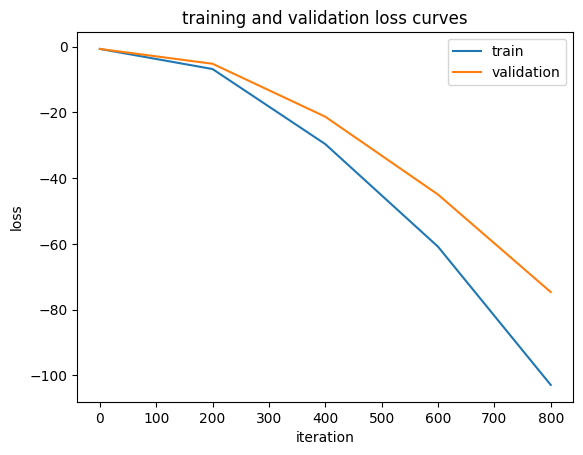

In [98]:
iters = [iter * ITERS_PER_EVAL for iter in range(len(train_losses))]
plt.plot(iters, train_losses, label='train')
plt.plot(iters, val_losses, label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('training and validation loss curves')
plt.legend()
plt.show()

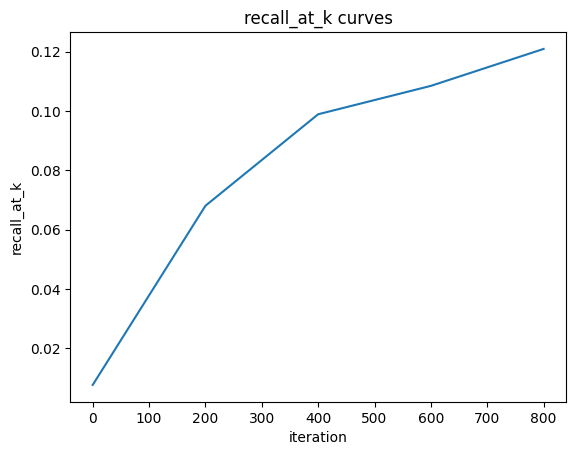

In [99]:
f2 = plt.figure()
plt.plot(iters, val_recall_at_ks, label='recall_at_k')
plt.xlabel('iteration')
plt.ylabel('recall_at_k')
plt.title('recall_at_k curves')
plt.show()

In [100]:
# evaluate on test set
model.eval()
test_edge_index = test_edge_index.to(device)

test_loss, test_recall, test_precision, test_ndcg = evaluation(model, 
                                                               test_edge_index, 
                                                               [train_edge_index, val_edge_index], 
                                                               K, 
                                                               LAMBDA
                                                              )

print(f"[test_loss: {round(test_loss, 5)}, test_recall@{K}: {round(test_recall, 5)}, test_precision@{K}: {round(test_precision, 5)}, test_ndcg@{K}: {round(test_ndcg, 5)}")

[test_loss: -108.02733, test_recall@20: 0.12384, test_precision@20: 0.04284, test_ndcg@20: 0.08748


In [101]:
rating_df['timestamp_norm'] = pd.to_datetime(rating_df['timestamp'], unit='s')

In [102]:
rating_df.head()

,userId,movieId,rating,timestamp,timestamp_norm
0,0,0,4.0,964982703,2000-07-30 18:45:03
1,0,2,4.0,964981247,2000-07-30 18:20:47
2,0,5,4.0,964982224,2000-07-30 18:37:04
3,0,43,5.0,964983815,2000-07-30 19:03:35
4,0,46,5.0,964982931,2000-07-30 18:48:51


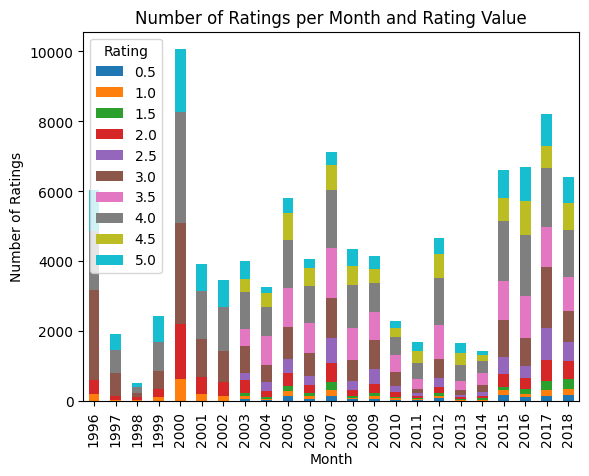

In [103]:
monthly_ratings = rating_df.groupby([rating_df['timestamp_norm'].dt.to_period('Y'), 'rating'])['rating'].count().unstack()
monthly_ratings.plot(kind='bar', stacked=True)
plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Month and Rating Value')
plt.legend(title='Rating')
plt.show()

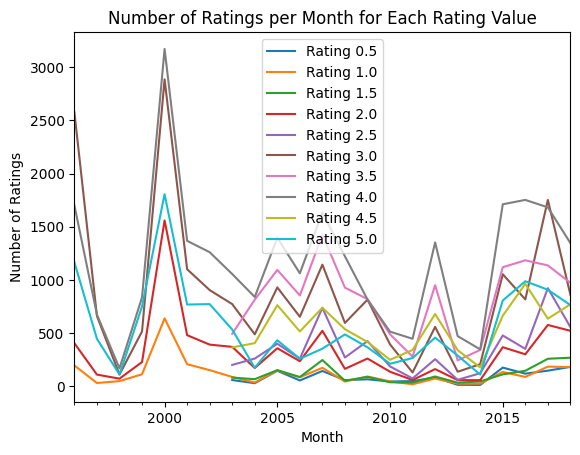

In [104]:
# Group data by month and rating, then unstack for plotting
monthly_ratings = rating_df.groupby([rating_df['timestamp_norm'].dt.to_period('Y'), 'rating'])['rating'].count().unstack()

# Plot all ratings on the same figure
plt.figure()  # Create only one figure
for rating in monthly_ratings.columns:
    monthly_ratings[rating].plot(kind='line', label=f'Rating {rating}')  # Plot each rating with a label

plt.xlabel('Month')
plt.ylabel('Number of Ratings')
plt.title('Number of Ratings per Month for Each Rating Value')  # Overall title
plt.legend()  # Show the legend
plt.show()

In [ ]:
import copy
import random

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch_geometric.utils import degree, structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_sparse import SparseTensor, matmul
from tqdm import tqdm


# ... (Previous code for data loading, preprocessing, and LightGCN model definition)

def create_non_iid_partitions(rating_df, num_clients):
    """Splits the data into non-IID partitions based on user groups."""
    # Sort data by user ID to introduce bias
    sorted_ratings = rating_df.sort_values('userId')

    # Calculate data splits based on the sorted data
    splits = np.array_split(sorted_ratings, num_clients)
    return splits


def federated_learning(model, client_data, num_rounds, local_epochs, batch_size, lr, lambda_val, k):
    """Performs federated learning with the LightGCN model."""

    train_losses = []  # Loss at each epoch for each client
    val_losses = []
    val_recalls = []  # averaged across clients
    val_precisions = [] # averaged across clients
    val_ndcgs = []  # averaged across clients

    global_model = copy.deepcopy(model)
    client_models = [copy.deepcopy(model) for _ in range(len(client_data))]

    for round_num in range(num_rounds):
        print(f"Starting round {round_num + 1}/{num_rounds}")

        round_train_losses = [] # Accumulate losses during a round
        client_train_losses = [] # accumulate losses for clients in each round to average

        # ... (Client updates) ...

        # Aggregate metrics to plot
        avg_client_loss_in_round = sum(client_train_losses) / len(client_train_losses) if client_train_losses else 0 # Prevent errors if all client indices were skipped due to empty datasets
        train_losses.append(avg_client_loss_in_round)  # Add to overall training losses

        # Client updates
        for client_idx, client_model in enumerate(client_models):
            print(f"Training client {client_idx + 1}/{len(client_data)}")
            client_optimizer = optim.Adam(client_model.parameters(), lr=lr)
            client_edge_index = build_edge_index(client_data[client_idx])
            if client_edge_index.shape[1] == 0:  # Added check
                print(f"Client {client_idx+1} has no data in this round. Skipping...")
                continue

            # Local training loop
            client_model.train()  # Set model to training mode
            for epoch in range(local_epochs):
                for batch in create_batches(client_edge_index, batch_size=batch_size):
                    if batch.shape[1] == 0:  # Additional check within batch loop
                        continue
                    client_optimizer.zero_grad()

                    # Get embeddings and compute loss
                    users_emb_final, users_emb_0, pos_items_emb_final, pos_items_emb_0, \
                        neg_items_emb_final, neg_items_emb_0 = get_embs_for_bpr(client_model, batch)

                    loss = bpr_loss(users_emb_final, users_emb_0,
                                    pos_items_emb_final, pos_items_emb_0,
                                    neg_items_emb_final, neg_items_emb_0,
                                    lambda_val)

                    loss.backward()
                    client_optimizer.step()
                    round_train_losses.append(loss.item()) # append loss for each epoch

        train_losses.extend(round_train_losses)  # Add a rounds epoch losses to the overall list
        # Server aggregation (FedAvg)
        with torch.no_grad():
            global_weights = global_model.state_dict()
            for key in global_weights:
                global_weights[key] = torch.stack([client_models[i].state_dict()[key]
                                                for i in range(len(client_data))]).mean(0)
            global_model.load_state_dict(global_weights)
            for client_model in client_models:
                client_model.load_state_dict(global_weights)  # Distribute back

        # Evaluation (Compute losses and metrics ONLY ONCE per round)
        with torch.no_grad():
            combined_edge_index = torch.cat([build_edge_index(client_data[i]) for i in range(len(client_data)) if build_edge_index(client_data[i]).shape[1]!=0], dim=1) # Combine data from non-empty clients
            if combined_edge_index.shape[1]==0: # Handle case where all clients have empty data
                print("No data available to combined_edge_index this round, skipping evaluation.")
                continue

            val_loss, recall, precision, ndcg = evaluation(global_model, combined_edge_index, [], k, lambda_val)

            val_losses.append(val_loss)  # Append ONE loss per round

            val_recalls.append(recall)
            val_precisions.append(precision)
            val_ndcgs.append(ndcg)
            print(f"Round {round_num + 1} Global Metrics: test_loss={test_loss:.4f}, "
                f"recall@{k}={recall:.4f}, precision@{k}={precision:.4f}, ndcg@{k}={ndcg:.4f}")


    # After federated learning is complete
    plot_training_loss(train_losses, val_losses, num_rounds, local_epochs)
    plot_metrics(val_recalls, val_precisions, val_ndcgs, k, num_rounds)
    return global_model


def build_edge_index(df):
    return convert_r_mat_edge_index_to_adj_mat_edge_index(
        torch.LongTensor(load_edge_csv(df, 'userId', 'movieId', 'rating', rating_threshold=3.5))
    )


def create_batches(edge_index, batch_size):
    num_edges = edge_index.shape[1]
    for start in range(0, num_edges, batch_size):
        end = min(start + batch_size, num_edges)
        yield edge_index[:, start:end]


# Federated learning functions (create_non_iid_partitions, federated_learning, build_edge_index, create_batches)

# Example usage:
NUM_CLIENTS = 5
CLIENT_DATA = create_non_iid_partitions(rating_df, NUM_CLIENTS)


# Create and train the federated model
federated_model = federated_learning(model, CLIENT_DATA, num_rounds=5, local_epochs=5,
                                    batch_size=BATCH_SIZE, lr=LR, lambda_val=LAMBDA, k=K)


In [106]:
def sample_mini_batch(batch_size, edge_index):
    """Randomly samples indices of a minibatch given an adjacency matrix

    Args:
        batch_size (int): minibatch size
        edge_index (torch.Tensor): 2 by N list of edges

    Returns:
        tuple: user indices, positive item indices, negative item indices
    """
    num_pos_edges = edge_index.shape[1]
    if num_pos_edges == 0:  # Check for empty edge index
        # Handle empty case (e.g., return empty tensors)
        return torch.LongTensor([]), torch.LongTensor([]), torch.LongTensor([])

    edges = structured_negative_sampling(edge_index)
    edges = torch.stack(edges, dim=0)

    # Ensure batch size doesn't exceed available positive edges
    batch_size = min(batch_size, num_pos_edges)  # Crucial change!

    indices = random.choices([i for i in range(edges[0].shape[0])], k=batch_size)
    batch = edges[:, indices]
    user_indices, pos_item_indices, neg_item_indices = batch[0], batch[1], batch[2]
    return user_indices, pos_item_indices, neg_item_indices

In [112]:
import matplotlib.pyplot as plt

def plot_training_loss(train_losses, val_losses, num_rounds, local_epochs):
    """Plots the training loss."""
    epochs = range(len(train_losses))    # x axis corresponds to each local epoch, len(train_losses)
    rounds = range(0, len(train_losses), local_epochs//NUM_CLIENTS) # Correct calculation

    plt.plot(epochs, train_losses, label='Training Loss')  # training loss is per epoch
    plt.plot(rounds, val_losses, label='Validation Loss')  # validation loss is per round
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()



def plot_metrics(recall_list, precision_list, ndcg_list, k, num_rounds):
    """Plots the recall, precision, and NDCG metrics."""
    rounds = [i for i in range(1, num_rounds + 1)]  # rounds not epoch
    plt.plot(rounds, recall_list, label=f'Recall@{k}')
    plt.plot(rounds, precision_list, label=f'Precision@{k}')
    plt.plot(rounds, ndcg_list, label=f'NDCG@{k}')
    plt.xlabel('Round')  # rounds not epoch
    plt.ylabel('Metric Value')
    plt.title('Evaluation Metrics')
    plt.legend()
    plt.show()